In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras as keras

# Used for Confusion Matrix
from sklearn import metrics
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# Is CUDA installed?
print('Is Cuda installed?')
tf.test.is_built_with_cuda()

Is Cuda installed?


True

In [3]:
from tensorflow.python.platform import build_info as tf_build_info
print('Cuda Version')
print(tf_build_info.cuda_version_number)

Cuda Version
10.1


In [4]:
# Limiting GPU memory growth (stopping it crash)
# From https://www.tensorflow.org/guide/gpu

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
# load dataset
dataset = read_csv('D:/nils/projects/dissertation/dataset_cpu_hog-exp2.csv', header=0, index_col=False)
#dataset = df
dataset

,y,asa_high_cpu_Prod126,Defect2938_Defection_in_memory,extremely_long_cpu_hog,long_cpu_hog_Prod126,low_memory_Prod126,memory_used_greater_than_100percent_Prod334,Prod128_compliancy_checks_CPU_memory_failure_Prod126,Prod359_Defect309_Share_line_memory,snmp_cpu_hog_Prod126,hit_severity
0,0,1,0,0,1,1,0,0,0,1,0
1,0,1,0,0,1,1,0,0,0,1,0
2,0,1,0,0,1,1,0,0,0,1,0
3,0,1,0,0,1,1,0,0,0,1,0
4,0,1,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
80706,1,0,0,0,1,0,0,0,0,0,2
80707,0,1,0,1,0,0,1,0,0,1,0
80708,0,0,0,0,1,0,0,0,0,0,1
80709,1,0,0,0,1,0,0,0,0,0,2


In [7]:
#dataset = dataset.drop('CPU_1',axis=1)

len(dataset)

80711

In [8]:
dataset.sum()

y                                                       11339
asa_high_cpu_Prod126                                    47498
Defect2938_Defection_in_memory                           7882
extremely_long_cpu_hog                                  37207
long_cpu_hog_Prod126                                    56090
low_memory_Prod126                                       4270
memory_used_greater_than_100percent_Prod334             41952
Prod128_compliancy_checks_CPU_memory_failure_Prod126     1957
Prod359_Defect309_Share_line_memory                      2416
snmp_cpu_hog_Prod126                                    43909
hit_severity                                            41768
dtype: int64

In [9]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# This normalises the severity -  other variables are already binary factors so re not impacted

# specify the look Back
n_look_back = 100
n_features = len(dataset.columns)

values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)



# Creates time series dataframe
# frame as supervised learning
reframed = series_to_supervised(scaled, n_look_back, 1)
print(reframed.shape)
reframed

(80611, 1111)


,var1(t-100),var2(t-100),var3(t-100),var4(t-100),var5(t-100),var6(t-100),var7(t-100),var8(t-100),var9(t-100),var10(t-100),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
100,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
101,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000
102,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
103,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
104,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80706,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667
80707,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
80708,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333
80709,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667


In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_look_back * n_features
x_train, y_train = train[:, :n_obs], train[:, -n_features]
x_test, y_test = test[:, :n_obs], test[:, -n_features]
print(x_train.shape, len(x_train), y_train.shape)

x_train_2d = x_train
x_test_2d = x_test

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], n_look_back, n_features))
x_test = x_test.reshape((x_test.shape[0], n_look_back, n_features))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)



(56427, 1100) 56427 (56427,)
(56427, 100, 11) (56427,) (24184, 100, 11) (24184,)


In [11]:
x_train 

n_train_hours



56427

In [57]:
# design simple network
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(32))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100, 128)          71680     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 64)           49408     
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 133,537
Trainable params: 133,537
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
# fit network
history = model.fit(x_train, y_train, epochs=50 , batch_size=500, validation_data=(x_test, y_test), verbose=1, shuffle=False)


Train on 56427 samples, validate on 24184 samples
Epoch 1/50
56427/56427 [==============================] - 26s 460us/step - loss: 0.3341 - accuracy: 0.9038 - val_loss: 0.6936 - val_accuracy: 0.7363
Epoch 2/50
56427/56427 [==============================] - 26s 457us/step - loss: 0.3071 - accuracy: 0.9122 - val_loss: 0.7279 - val_accuracy: 0.7363
Epoch 3/50
56427/56427 [==============================] - 26s 460us/step - loss: 0.3066 - accuracy: 0.9122 - val_loss: 0.7358 - val_accuracy: 0.7363
Epoch 4/50
56427/56427 [==============================] - 25s 445us/step - loss: 0.3059 - accuracy: 0.9122 - val_loss: 0.7364 - val_accuracy: 0.7363
Epoch 5/50
56427/56427 [==============================] - 24s 433us/step - loss: 0.3055 - accuracy: 0.9122 - val_loss: 0.7333 - val_accuracy: 0.7363
Epoch 6/50
56427/56427 [==============================] - 24s 433us/step - loss: 0.3048 - accuracy: 0.9122 - val_loss: 0.7339 - val_accuracy: 0.7363
Epoch 7/50
56427/56427 [==============================] 

<Figure size 640x480 with 0 Axes>

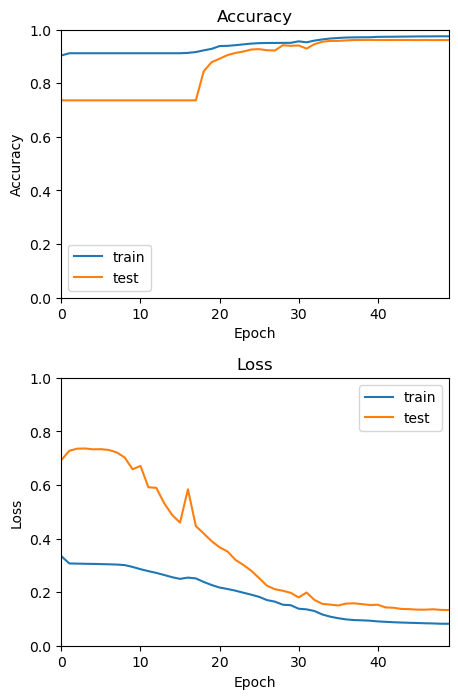

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

plt.clf()
G = gridspec.GridSpec(2, 1,hspace=0.3)
plt.figure(figsize=(5,8))

axes_a = plt.subplot(G[0,0])
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
pyplot.legend()
plt.ylim(0,1)
plt.xlim(0,49)

axes_b = plt.subplot(G[1,0])
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
pyplot.legend()
plt.ylim(0,1)
plt.xlim(0,49)

plt.savefig('acc_loss_module_plot.svg', transparent=True)
pyplot.show()

In [60]:
RNN_pred_y = model.predict(x_test, verbose=1)


24184/24184 [==============================] - 27s 1ms/step


In [61]:
model.save('model_cpu_hog_module.h5')

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, RNN_pred_y)

In [63]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

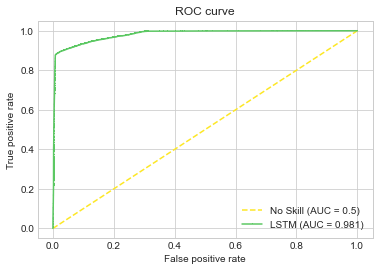

In [64]:
plt.figure(1)

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill (AUC = 0.5)')
pyplot.plot(fpr_keras, tpr_keras, marker=',', label='LSTM (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [65]:
from sklearn.metrics import confusion_matrix

RNN_pred_y_class = model.predict_classes(x_test, verbose=1)

24184/24184 [==============================] - 27s 1ms/step


In [66]:
def cm(y_test, pred_y_class):
    cm = metrics.confusion_matrix(y_test, pred_y_class)
    fn = cm[1][0]
    tp = cm[1][1]
    fnr = fn/(tp+fn)
    return cm, fnr

In [67]:
cmRNN, fnrRNN = cm(y_test, RNN_pred_y_class)

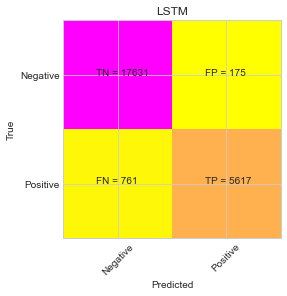

In [68]:
plt.imshow(cmRNN, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('LSTM')
plt.ylabel('True')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmRNN[i][j]))

#plt.savefig('conf1_plot.svg', transparent=True)
plt.show()

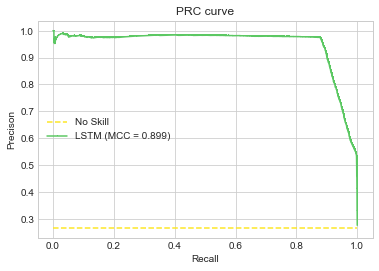

In [69]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_RNN = f1_score(y_test, RNN_pred_y_class)
MCC_RNN = matthews_corrcoef(y_test,RNN_pred_y_class)


pr_RNN, re_RNN, th = precision_recall_curve(y_test, RNN_pred_y)

plt.figure(2)
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(re_RNN, pr_RNN, marker=',', label='LSTM (MCC = {:.3f})'.format(MCC_RNN))
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')
plt.show()

In [70]:
# Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression 

logReg = LogisticRegression(max_iter=10000, verbose=1)

In [72]:
logReg.fit(x_train_2d, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


LogisticRegression(max_iter=10000, verbose=1)

In [73]:
# Make predictions on entire test data
pred_y_class = logReg.predict(x_test_2d)
pred_y_prob = logReg.predict_proba(x_test_2d)
pred_y_prob = pred_y_prob[:, 1]

In [74]:
# Use score method to get accuracy of model
score = logReg.score(x_test_2d, y_test)
print(score)

0.9139927224611313


In [75]:
# confusion matrix

cmLogReg, fnrLogReg = cm(y_test, pred_y_class)

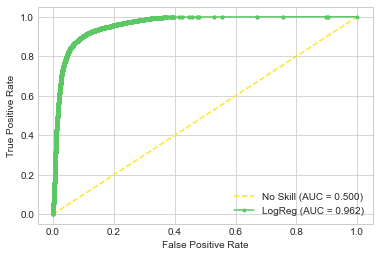

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, pred_y_prob)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, pred_y_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = {:.3f})'.format(ns_auc))
pyplot.plot(LogReg_fpr, LogReg_tpr, marker='.', label='LogReg (AUC = {:.3f})'.format(LogReg_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

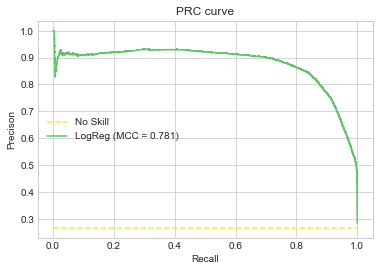

In [77]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_LogReg = f1_score(y_test, pred_y_class)
MCC_LogReg = matthews_corrcoef(y_test,pred_y_class)


pr_LogReg, re_LogReg, th = precision_recall_curve(y_test, pred_y_prob)

plt.figure(2)
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(re_LogReg, pr_LogReg, marker=',', label='LogReg (MCC = {:.3f})'.format(MCC_LogReg))
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')
plt.show()

In [78]:
# AdaBoost Classifier

In [79]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [80]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
classifier.fit(x_train_2d, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

In [81]:
pred_y_class = classifier.predict(x_test_2d)
pred_y_prob = classifier.predict_proba(x_test_2d)
pred_y_prob = pred_y_prob[:, 1]

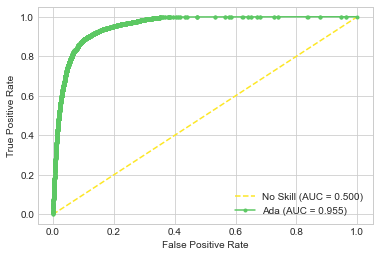

In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
ada_auc = roc_auc_score(y_test, pred_y_prob)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_test, pred_y_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = {:.3f})'.format(ns_auc))
pyplot.plot(ada_fpr, ada_tpr, marker='.', label='Ada (AUC = {:.3f})'.format(ada_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

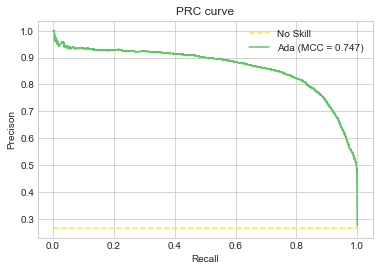

In [83]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_Ada = f1_score(y_test, pred_y_class)
MCC_Ada = matthews_corrcoef(y_test,pred_y_class)


pr_Ada, re_Ada, th = precision_recall_curve(y_test, pred_y_prob)

plt.figure(2)
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(re_Ada, pr_Ada, marker=',', label='Ada (MCC = {:.3f})'.format(MCC_Ada))
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')
plt.show()

In [84]:
cmAdaBoost, fnrAdaBoost = cm(y_test, pred_y_class)
print(cmAdaBoost)

[[16671  1135]
 [ 1229  5149]]


In [85]:
classifier.score(x_train_2d, y_train)

0.9563329611710706

In [86]:
# XGBoost

In [87]:
from xgboost import XGBClassifier, plot_importance
import pandas as pd
from sklearn.metrics import accuracy_score

In [88]:
xgb1 = XGBClassifier(max_depth=6, 
                     eta=0.1,
                     verbosity=1,
                     objective='binary:logistic',
                     n_estimators=1000,
                     learning_rate=0.05).fit(x_train_2d, y_train, eval_metric='auc')


In [89]:
    #Predict training set:
    pred_y_class = xgb1.predict(x_test_2d)
    pred_y_prob = xgb1.predict_proba(x_test_2d)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy:") 
    print (metrics.accuracy_score(y_test,pred_y_class))
    print ('AUC Score:')
    print (metrics.roc_auc_score(y_test,pred_y_prob))


Model Report
Accuracy:
0.952820046311611
AUC Score:
0.9801608338108504


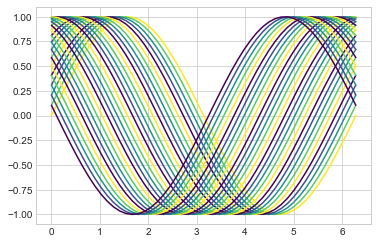

In [90]:
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

plt.style.use('seaborn-whitegrid')

# get colormap
cmap=plt.cm.viridis_r
# build cycler with 5 equally spaced colors from that colormap
c = cycler('color', cmap(np.linspace(0,1,5)) )
# supply cycler to the rcParam
plt.rcParams["axes.prop_cycle"] = c


x = np.linspace(0,2*np.pi)
f = lambda x, phase:np.sin(x+phase)
for i in range(30):
    plt.plot(x,f(x,i/30.*np.pi) )

plt.show()

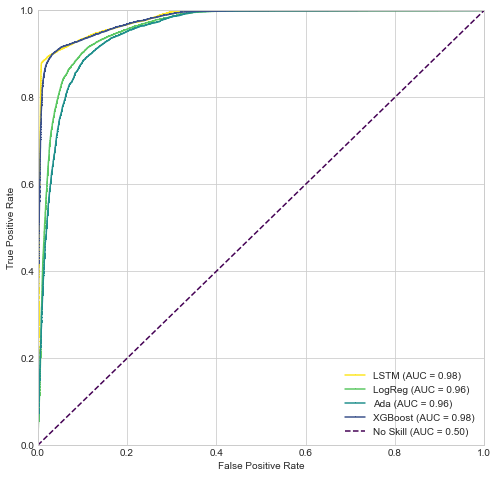

In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, pred_y_prob)

plt.figure(figsize=(8,8))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, pred_y_prob)
# plot the roc curve for the model
pyplot.plot(fpr_keras, tpr_keras, marker=',', label='LSTM (AUC = {:.2f})'.format(auc_keras))
pyplot.plot(LogReg_fpr, LogReg_tpr, marker=',', label='LogReg (AUC = {:.2f})'.format(LogReg_auc))
pyplot.plot(ada_fpr, ada_tpr, marker=',', label='Ada (AUC = {:.2f})'.format(ada_auc))
pyplot.plot(xgb_fpr, xgb_tpr, marker=',', label='XGBoost (AUC = {:.2f})'.format(xgb_auc))
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = {:.2f})'.format(ns_auc))
# axis labels
plt.xlim(0,1)
plt.ylim(0,1)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot

plt.savefig('roc_module_plot.svg', transparent=True)
pyplot.show()

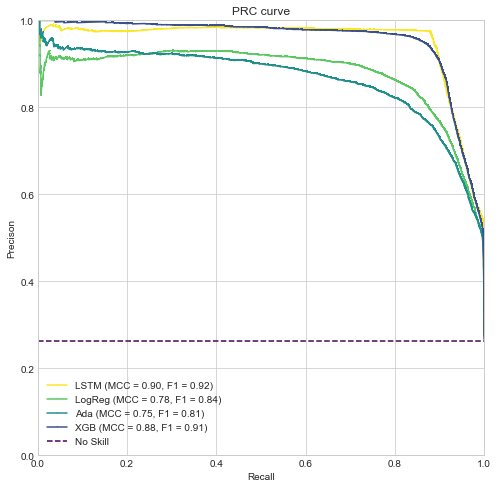

In [92]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_xgb = f1_score(y_test, pred_y_class)
MCC_xgb = matthews_corrcoef(y_test,pred_y_class)


pr_xgb, re_xgb, th = precision_recall_curve(y_test, pred_y_prob)

plt.figure(figsize=(8,8))
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot(re_RNN, pr_RNN, marker=',', label='LSTM (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_RNN, F1_RNN))
pyplot.plot(re_LogReg, pr_LogReg, marker=',', label='LogReg (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_LogReg, F1_LogReg))
pyplot.plot(re_Ada, pr_Ada, marker=',', label='Ada (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_Ada, F1_Ada))
pyplot.plot(re_xgb, pr_xgb, marker=',', label='XGB (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_xgb, F1_xgb))
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='best')

plt.savefig('prc_curve_module_plot.svg', transparent=True)

plt.show()


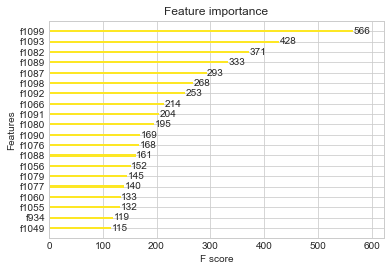

In [93]:

plot_importance(xgb1, max_num_features = 20)
pyplot.show()


    


In [94]:
cmXGB, fnrXGB = cm(y_test, pred_y_class)
print(cmXGB)
fnrXGB

[[17432   374]
 [  767  5611]]


0.1202571338977736

<Figure size 432x288 with 0 Axes>

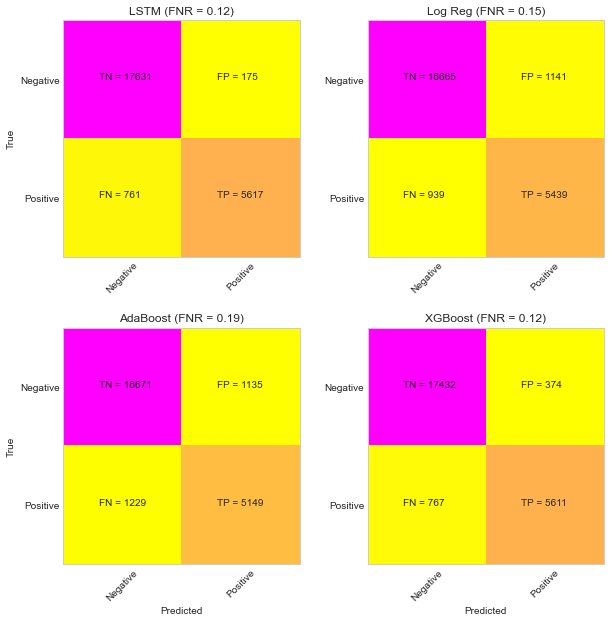

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.clf()
G = gridspec.GridSpec(2, 2,hspace=0.3)
plt.figure(figsize=(10,10))


axes_4 = plt.subplot(G[0,0])
plt.grid(b=None)
plt.imshow(cmRNN, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('LSTM (FNR = {:.2f})'.format(fnrRNN))
plt.ylabel('True')
#plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmRNN[i][j]))

axes_1 = plt.subplot(G[1,0])
plt.grid(b=None)
plt.imshow(cmAdaBoost, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('AdaBoost (FNR = {:.2f})'.format(fnrAdaBoost))
plt.ylabel('True')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmAdaBoost[i][j]))
               
axes_2 = plt.subplot(G[0,1])
plt.grid(b=None)
plt.imshow(cmLogReg, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('Log Reg (FNR = {:.2f})'.format(fnrLogReg))
#plt.ylabel('True')
#plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmLogReg[i][j]))
        
axes_3 = plt.subplot(G[1,1])
plt.grid(b=None)
plt.imshow(cmXGB, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('XGBoost (FNR = {:.2f})'.format(fnrXGB))
#plt.ylabel('True')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmXGB[i][j]),)

plt.savefig('cm_module_plot.svg', transparent=True)
plt.show()
